# PREPROCESSING

This file is used to create versions of preprocessment, for the modelling stage. It includes the treatment of missing values, inconsistent values, as well as feature engineering, both elementary and advanced. It does not include, scaling, outlier removal or feature selection of any kind.

Each transformation is performed both on train, as well as test data - wherever applicable. This script was written with the assistance of artificial tools, to generate boilerplates, and correct grammar; the authors attest to its correctness with penalty of grade.

DISCLAIMER: The steps taken in this notebook to treat the data do not make a superlative effort to justify or demonstrate themselves. Look instead to the Data Exploration notebook, that goes into lengthy detail over the reasoning behind each preprocessment choice. 

## Libraries

Libraries used in the elaboration of this notebook.

In [1]:
# STL
import os 
import re
import math
from collections import Counter

# Ingestion and Manipulation
import json
import numpy as np
import pandas as pd

# Display options
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

## Helper Functions

Assist in the inspection and execution of preprocessment.

### to_snake_case

Converts a string to snake_case.

In [2]:
def to_snake_case(input_string):
    """
    Converts a given string to snake_case.

    Args:
        input_string (str): The string to convert.

    Returns:
        str: The snake_case version of the input string.
    """
    # Replace spaces or hyphens with underscores
    input_string = re.sub(r"[\s\-\/]+", "_", input_string)
    
    # Add underscores between camelCase or PascalCase words
    input_string = re.sub(r"([a-z])([A-Z])", r"\1_\2", input_string)
    
    # Convert to lowercase
    snake_case_string = input_string.lower()
    
    return snake_case_string

### summarize_dataframe

Summarizes dataframe values information

In [3]:
def summarize_dataframe(df):
    """
    Provides a detailed summary of all variables in a DataFrame, including unique values,
    value counts, and the total number of unique values.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: A summary DataFrame with columns:
            - variable: Column names in the input DataFrame.
            - dtype: Data types of the columns.
            - unique_count: Number of unique values in each column.
            - unique_values: A sample of unique values for each column.
            - value_counts: Value counts (top 5 values with counts) for each column.
    """
    summary = {
        "variable": [],
        "dtype": [],
        "unique_count": [],
        "unique_values": [],
        "value_counts": []
    }
    
    for col in df.columns:
        summary["variable"].append(col)
        summary["dtype"].append(df[col].dtype)
        summary["unique_count"].append(df[col].nunique())
        summary["unique_values"].append(df[col].unique()[:5])  # Limit to first 5 unique values for readability
        summary["value_counts"].append(df[col].value_counts().head(5).to_dict())  # Top 5 most frequent values
    
    return pd.DataFrame(summary)


### compare_dataframe_columns

Checks the columns of two dataframes highlighting their differences.

In [4]:
def compare_dataframe_columns(df1, df2):
    """
    Compares the columns of two DataFrames and identifies their intersection, 
    as well as columns unique to each DataFrame.

    Args:
        df1 (pandas.DataFrame): The first DataFrame to compare.
        df2 (pandas.DataFrame): The second DataFrame to compare.

    Returns:
        tuple: A tuple containing:
            - common_columns (pandas.Index): Columns present in both DataFrames.
            - only_in_df1 (set): Columns only in df1.
            - only_in_df2 (set): Columns only in df2.
    """
    common_columns = df1.columns.intersection(df2.columns)

    if len(common_columns) == len(df1.columns) == len(df2.columns):
        print("Both dataframes have the same columns.")
    
    else:
        print("The dataframes do not have the same columns.")
        print("Columns in df1 but not in df2:", set(df1.columns) - set(df2.columns))
        print("Columns in df2 but not in df1:", set(df2.columns) - set(df1.columns))


### summarize_missing_information

Creates a dataframe with the relevant information regarding missing values.

In [5]:
def summarize_missing_information(df):
    """
    Aggregates information about missing values in a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: A summary DataFrame with columns:
            - variable: Column names in the input DataFrame.
            - dtype: Data types of the columns.
            - count: Total number of entries in each column.
            - unique: Number of unique values in each column.
            - missing: Count of missing values in each column.
            - pc_missing: Percentage of missing values in each column.
    """  
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])*100)))
        
    output = pd.DataFrame({
    'variable': variables, 
    'dtype': dtypes,
    'count': count,
    'unique': unique,
    'missing': missing, 
    'pc_missing': pc_missing
    })
    
    return output

### encode_missing_features

Encodes missing information present in features. 

In [6]:
def encode_missing_features(df, target):
    """
    Process a dfset to handle missingness by creating binary indicator columns for missing values.

    Parameters:
        df (pd.dfFrame): The dfset to process.
        return_column_names (bool, optional): Whether to return the names of new missing indicator columns.

    Returns:
        pd.dfFrame: The processed dfset with missing indicators added.
        list (optional): A list of the names of the new missing indicator columns 
                         (if return_column_names is True).
    """   
    # Iterate over columns to handle missingness
    for col in df.columns:
        if col in target:
            continue
        else:
            # Create a missing value indicator column
            missing_col_name = f'missing_{col}'
            df[missing_col_name] = df[col].isna().astype('float64')          



### fill_missing_dates

Forward fills missing dates

In [7]:
def fill_missing_dates(df, missing_dates, filling_dates, timedelta_days=3):
    """
    Fills missing date values by carrying forward the last known date and adding a specified timedelta.
    
    Parameters:
        df (pd.dfFrame): The dfset containing the date features.
        missing_dates (list): List of column names with missing date values to fill.
        filling_dates (list): List of columns where missing values need to be filled.
        timedelta_days (int, optional): The number of days to add when filling missing values. Default is 3.
        
    Returns:
        pd.dfFrame: The dfset with missing dates filled.
    """
    # Apply filling only for rows where any missing dates exist
    df.loc[df[missing_dates].any(axis=1), filling_dates] = \
        df.loc[df[missing_dates].any(axis=1), filling_dates].apply(
            lambda row: row.fillna(row.min() + pd.Timedelta(days=timedelta_days)), axis=1
        )



### encode_date_distances

Encodes pairwise distances between dates, as number of days.

In [8]:
def encode_date_distances(df, datetime_features):
    """
    Computes pairwise distances (in days) between each datetime feature in a dfset.

    Parameters:
        df (pd.dfFrame): The dfset containing datetime features.
        datetime_features (list): List of column names that are datetime features.
        return_column_names (bool, optional): Whether to return the names of new distance columns.

    Returns:
        pd.dfFrame: The updated dfset with pairwise distance columns added.
        list (optional): A list of the names of the new distance columns (if return_column_names is True).
    """
    # Mapping for datetime column abbreviations
    col_mapping = {
        'c_2_date': 'c2',
        'c_3_date': 'c3',
        'assembly_date': 'asb',
        'first_hearing_date': 'fh'
    }
    
    distance_features = []  # To store the names of the new columns

    # Loop through the datetime columns and calculate pairwise distances
    for i, col in enumerate(datetime_features):
        for other_col in datetime_features[i + 1:]:
            # Use the mapping to define the column name for the distance feature
            col_num = col_mapping.get(col, -1)
            other_col_num = col_mapping.get(other_col, -1)
            
            # Skip if one of the columns isn't in the mapping
            if col_num == -1 or other_col_num == -1:
                continue
            
            col_name = f'dd_{col_num}_{other_col_num}'
            
            # Calculate the distance in days if both dates are not NaT
            df[col_name] = df.apply(
                lambda row: (row[col] - row[other_col]).days
                            if pd.notna(row[col]) and pd.notna(row[other_col])
                            else np.nan,
                axis=1
            ).astype('float64')



### encode_order_dates

Encodes the order between the dates of events.

In [9]:
def encode_order_dates(df, datetime_features):
    """
    Encode the dates based on their order and matches, assigning a unique binary code to each date.

    Parameters:
        df (pd.DataFrame): The dataset to process.
        datetime_features (list): List of column names containing datetime features to encode.
        return_column_names (bool, optional): Whether to return the names of the newly created binary columns.

    Returns:
        pd.DataFrame: The updated dataset with binary columns representing the encoded dates.
        list (optional): A list of the new binary column names (if return_column_names is True).
    """
    # Deep copy to not alter the list in place
    these_datetime_features = datetime_features.copy()
    these_datetime_features.remove('accident_date')
    
    # Define the list of binary columns (16 total)
    do_columns = [f'do_{i+1}' for i in range(len(these_datetime_features) * 4)]
   
    # Iterate through each row and process
    for _, row in df.iterrows():
        # Extract the dates from the row dynamically using datetime_features
        dates = [row[col] for col in these_datetime_features]
        
        # Sort the dates and calculate their position and match count
        sorted_dates = sorted(dates)
        
        # Create the binary vector for the row
        binary_vector = []
        for date in dates:
            matches = dates.count(date)  # Count how many times this date appears
            position = sorted_dates.index(date)  # Position in the sorted list
            
            # First 2 bits: number of matches (0-3), Last 2 bits: position in the order (0-3)
            binary_value = f'{matches:02b}{position:02b}'
            binary_vector.extend([float(bit) for bit in binary_value])  # Convert bits to float for consistency
        
        # Assign the binary values to the corresponding columns in the DataFrame
        for col, value in zip(do_columns, binary_vector):
            df.at[_, col] = value  # Assign each bit to its respective column



### parse_date_components

Parses date components into into features.

In [10]:
def parse_date_components(df, datetime_features):
    """
    Extract year, month, and day components from datetime columns and add them to the DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to process.
        datetime_features (list): List of column names that are datetime features.
        return_column_names (bool, optional): Whether to return the names of the new date component columns.

    Returns:
        list (optional): A list of the names of the new date component columns (if return_column_names is True).
    """
    for col in datetime_features:
        # Build the feature names
        year_col = f'{col}_year'
        month_col = f'{col}_month'
        day_col = f'{col}_day'
        
        # Extract year, month, and day components
        df[year_col] = df[col].dt.year.astype('float64')
        df[month_col] = df[col].dt.month.astype('float64')
        df[day_col] = df[col].dt.day.astype('float64')           



## Data Ingestion

Data was loaded and our prefered naming convention (PEP-8 - snake_case) was adopted.

In [11]:
# Ingest at the working directory
train = pd.read_csv('../data/train_data.csv', low_memory=False)

# Convert variables to snake case
train.rename(columns={colname : to_snake_case(colname) for colname in train.columns}, inplace=True, errors='ignore')

In [12]:
# Ingest at working directory
test = pd.read_csv('../data/test_data.csv', low_memory=False)

# Convert variables to snake case
test.rename(columns={colname : to_snake_case(colname) for colname in test.columns}, inplace=True, errors='ignore')

## Reindexing the dataframe with Claim Identifier

Converted to index, as it is the natural index for the data, to this end, both duplicates and inconsistent values were dropped.

In [13]:
# Dropping duplicates
train.drop_duplicates(subset=['claim_identifier'], inplace=True)

In [14]:
# Boolean mask to select the values of interest
id_mask_df = train[train['claim_identifier'].astype(str).str.len() != 7]
train = train.drop(id_mask_df.index)

print(f'Droping: {id_mask_df.shape[0]} rows')

Droping: 19444 rows


In [15]:
# claim_identifier is set as index to train dataframe
train = train.set_index(keys='claim_identifier')

In [16]:
# claim_identifier is set as index to test dataframe
test = test.set_index(keys='claim_identifier')

## Dropping useless columns

Columns which it was immediately evident will serve no purpose were dropped.

In [17]:
# Not present in test, empty column, unary
train = train.drop(columns=['agreement_reached', 'oiics_nature_of_injury_description', 'wcb_decision'])

In [18]:
# Empty column, unary 
test = test.drop(columns=['oiics_nature_of_injury_description'])

## Cohercing features to their expected data types

Each feature was cast into it's expected data type, with the errors being chatched as nan. The lists below define the rules.

In [19]:
# Datetime features were converted to datetime objects
date_features = [
    'accident_date'
    , 'first_hearing_date'
    , 'assembly_date'
    , 'c_2_date'
    , 'c_3_date'
]

# Categorical features were converted to category objects
categorical_features = [
    'district_name'
    , 'county_of_injury'
    , 'carrier_name'
    , 'carrier_type'
    , 'industry_code'
    , 'industry_code_description'
    , 'wcio_nature_of_injury_description'
    , 'wcio_nature_of_injury_code'
    , 'wcio_cause_of_injury_description'
    , 'wcio_cause_of_injury_code'
    , 'wcio_part_of_body_description'
    , 'wcio_part_of_body_code'
    , 'medical_fee_region'
    , 'zip_code'
    , 'alternative_dispute_resolution'
]

# Metric features were converted to float64 objects
metric_features = [
     'birth_year' 
    , 'age_at_injury'
    , 'gender'
    , 'number_of_dependents'
    , 'average_weekly_wage'
    , 'ime_4_count'
    , 'covid_19_indicator'
    , 'attorney_representative'
]

# The target feature was converted to a category object
target = 'claim_injury_type'

### Metric

All metric features, are converted to 'float64'.

In [20]:
# Following the Pythonic Zen "ask for forgiveness not for permission", we wrap out type casting in a try except, and deal with the exceptions.
for feature in metric_features:
    try:
        train[feature] = train[feature].astype('float64')
        
    except ValueError:
        train[feature] = train[feature].apply(lambda x: 1 if x in ['M', 'Y'] else 0 if x in ['F', 'N'] else np.nan if x == 'X' else np.nan).astype('float64')

In [21]:
# Same for the test set
for feature in metric_features:
    try:
        test[feature] = test[feature].astype('float64')
        
    except ValueError:     
        test[feature] = test[feature].apply(lambda x: 1 if x in ['M', 'Y'] else 0 if x in ['F', 'N'] else np.nan if x == 'X' else np.nan).astype('float64')

### Categorical

All categorical features, are converted to category.

In [22]:
# We use apply, lambda to preserve nan's.

for feature in categorical_features:
    train[feature] = train[feature].apply(lambda x: x if x else np.nan).astype('category')

In [23]:
# We use apply, lambda to preserve nan's.

for feature in categorical_features:
    test[feature] = test[feature].apply(lambda x: x if x else np.nan).astype('category')

### Datetime

All datetime features, were coherced to datetime, to obtain NaT errors.

In [24]:
for feature in date_features:
    train[feature] = pd.to_datetime(train[feature], errors='coerce')

In [25]:
for feature in date_features:
    test[feature] = pd.to_datetime(test[feature], errors='coerce')

## Converting the target to category

We encode the target into a category.

In [26]:
# We also cast the feature itself to a category
train['claim_injury_type'] = train['claim_injury_type'].astype('category')

Per documentation, it was found that these identifiers must be of length 7.

## Feature Treament and Engineering 

This next portion of the notebook is dedicated to treating inconsistent values in variables, as well as engineering new ones in the process.

### Creating missing flags for all features

The missingness of each feature was represented as a binary indicator: a value of '1' indicated that the feature was missing, while a value of '0' signified that the feature was present in a given observation.

In [27]:
# Call the function to encode missing values in features into columns
encode_missing_features(
    train, target
)


In [28]:
# Call the function to encode missing values in features into columns
encode_missing_features(
    test, target
)


### Handling Date Features

Several transformations were applied to the date features:

    - Missing values for each observation were filled by carrying forward the last known date in the claim process, with all other missing values being populated accordingly.
    
    - The time intervals between the various date features were encoded into a set of distance variables.
    
    - The chronological order of events underlying the data was captured and encoded as a series of features.

#### Filling with last value carried forward

Similar to last observation carried forwards, a method commonly used in clinical trials and similar; we propagate the last observed date for each observation, into the remaining features

In [29]:
missing_dates = [
    'missing_assembly_date',
    'missing_c_2_date',
    'missing_c_3_date',
    'missing_first_hearing_date'
]

filling_dates = [
    'assembly_date',
    'c_2_date',
    'c_3_date',
    'first_hearing_date'
]

In [30]:
fill_missing_dates(
    train, missing_dates, filling_dates, timedelta_days=3
)

In [31]:
fill_missing_dates(
    test, missing_dates, filling_dates, timedelta_days=3
)

#### Encoding timedelta between dates

Under the assumption that the time between the date phenomena the dataset can be a significant predictor, pairwise distances were calculated.

In [32]:
encode_date_distances(
    train, date_features
)


In [33]:
encode_date_distances(
    test, date_features
)


#### Encoding date order with a customer rule

It was surmized that the order in which the events in the claim happened could have predictive power, so this order was encoded into a 16-bit string that could then be represented in 16 individual features. In this representation, each four bits represent a date; with the first two representing how many other dates are concomitant, and the next two, at which position in the order of events chain the date is located.

In [34]:
encode_order_dates(
    train, date_features
)   

In [35]:
encode_order_dates(
    test, date_features
)

#### Extracting atomic time components

Without intending to transform the problem into a Time Series analysis problem, but nonetheless assuming that there might be great importance in the periodicity of the data, the datetime variables were splitt into their year, month, day components.

In [36]:
parse_date_components(
    train, date_features
)

In [37]:
parse_date_components(
    test, date_features
)

#### Deterministic imputation of dates

The causal connection between age at injury, accident date and birth year was used to impute values as many missing values as possible. Since such type of imputation is deterministic, it is applicable to the test data, as it neither requires, nor infers information from the target variable

##### filling age_at_injury

An approximation to age at injury was obtained from accident date and birth year.

In [38]:
mask = train['age_at_injury'].isnull() & train['accident_date'].notnull() & train['birth_year'].notnull()
train.loc[mask, 'age_at_injury'] = train['accident_date_year'] - train['birth_year']

In [39]:
mask = test['age_at_injury'].isnull() & test['accident_date'].notnull() & test['birth_year'].notnull()
test.loc[mask, 'age_at_injury'] = test['accident_date_year'] - test['birth_year']

##### filling accident_date_year

The year value of the accident was deduced from the birth year and the age at which the accident occurred. 

In [40]:
mask = train['accident_date_year'].isnull() & train['birth_year'].notnull() & train['age_at_injury'].notnull()
train.loc[mask, 'accident_date_year']  = train['age_at_injury'] + train['birth_year']

In [41]:
mask = test['accident_date_year'].isnull() & test['birth_year'].notnull() & test['age_at_injury'].notnull()
test.loc[mask, 'accident_date_year'] = test['age_at_injury'] + test['birth_year']

### Correcting identified inconsistencies

A series of inconsistent values were treated, mostly, by setting to nan, or similar, for future imputation. These were either deduced using domain knowledge obtained through investigation; or through inference with to the respect nature of the phenomena these variables contain.

#### Accident date preceeds any claim event

Values for which the accident preceeded the claim were deemed defective, rather than fixing these entries we simply drop them, as imputation would be cumbersome, and likely misguided by speculation.

In [42]:
# applying the lt, less than operator to the given columns, with respect to accident_date
mask = train[['c_2_date', 'c_3_date', 'first_hearing_date', 'assembly_date']].lt(train['accident_date'], axis=0)

# Then we drop the values
train = train[~mask.any(axis=1)]

#### Claimants whose accident was being born

No clearer case of ad hoc ergo propter hoc could possibly be devised, thus such entries were set to nan.

In [43]:
# Using isclose() to dodge false negatives, and posistives in the equality to zero test due to floating point precision errors

In [44]:
train['age_at_injury_zero'] = np.isclose(train['age_at_injury'], 0).astype('float64')

# Ensure that we are not keeping any unwanted '0's, resulting from the previous deterministic imputation
train.loc[np.isclose(train['accident_date_year'], 0), 'accident_date_year'] = np.nan 
train.loc[np.isclose(train['age_at_injury'], 0), 'age_at_injury'] = np.nan

In [45]:
test['age_at_injury_zero'] = np.isclose(test['age_at_injury'], 0).astype('float64')

# Ensure that we are not keeping any unwanted '0's, resulting from the previous deterministic imputation
test.loc[np.isclose(test['accident_date_year'], 0), 'accident_date_year'] = np.nan
test.loc[np.isclose(test['age_at_injury'], 0), 'age_at_injury'] = np.nan

#### Child labour

As claims made by ineligible minors (under the age of fourteen) would not be evaluated by the commitee in question, entries where apparent child labor was detected were set to nan. 

In [46]:
# We re-abolish child labour
train.loc[train['age_at_injury'] < 14, 'missing_age_at_injury'] = 1
train.loc[train['age_at_injury'] < 14, 'age_at_injury'] = np.nan

In [47]:
test.loc[test['age_at_injury'] < 14, 'missing_age_at_injury'] = 1
test.loc[test['age_at_injury'] < 14, 'age_at_injury'] = np.nan

#### Correcting ime_4_count

Investigation into the ime_4_count feature showed that most of its values were nan. It was infered that as this feature refers to the count of IMEs and that the most natural condition is for no IMEs to exist, that all nans were to be replaced by '0's.

So all missing values in ime_4_count were imputed to '0.0' ('float64').

In [48]:
# Using isclose to dodge false negatives, and posistives in the equality to zero test due to floating point precision errors

In [49]:
train.loc[np.isclose(train['missing_ime_4_count'], 1, atol=1e-6) , 'ime_4_count'] = 0.0

In [50]:
test.loc[np.isclose(test['missing_ime_4_count'], 1, atol=1e-6) , 'ime_4_count'] = 0.0

#### Alternative Dispute Resolution, and Unionized workers

It was infered that in 'alternative_dispute_resolution' 'U' stands for 'Union', therefore we created a flag variable to signal this small wrinkle in the data. Addionally, the variable was then mapped to binary, where both 'Y', and 'U' map to 1, and 'N' mapped to 0. 

In [51]:
# We create the variable is_unionized in train
train.loc[:, 'is_unionized'] = train.loc[:, 'alternative_dispute_resolution'].isin(['U']).astype('float64')

In [52]:
# And in test
test.loc[:, 'is_unionized'] = test.loc[:, 'alternative_dispute_resolution'].isin(['U']).astype('float64')

In [53]:
# We then enforce the transformation to boolean as float64
train['alternative_dispute_resolution'] = \
    train['alternative_dispute_resolution'].apply(
        lambda x: 1.0 if x in ['U', 'Y'] else 0.0 if x in ['N'] else np.nan
    ).astype('float64')

In [54]:
# and the same for test 
test['alternative_dispute_resolution'] = \
    test['alternative_dispute_resolution'].apply(
        lambda x: 1.0 if x in ['U', 'Y'] else 0.0 if x in ['N'] else np.nan 
    ).astype('float64')

## Dimensionality reduction in Categorical Variables

Some categorical variables were thought to be eligible for grouping, as this would inherently reduces the number of dimensions needed when applying onehot encoding. So logical grouping of specific categorical features was attempted. 

In [55]:
train[
    [
    'wcio_cause_of_injury_description'
    , 'wcio_nature_of_injury_description'
    , 'wcio_part_of_body_description'
    , target
    ]
].head()

,wcio_cause_of_injury_description,wcio_nature_of_injury_description,wcio_part_of_body_description,claim_injury_type
claim_identifier,,,,
5393875,FROM LIQUID OR GREASE SPILLS,CONTUSION,BUTTOCKS,2. NON-COMP
5393091,REPETITIVE MOTION,SPRAIN OR TEAR,SHOULDER(S),4. TEMPORARY
5393889,OBJECT BEING LIFTED OR HANDLED,CONCUSSION,MULTIPLE HEAD INJURY,4. TEMPORARY
5393887,"HAND TOOL, UTENSIL; NOT POWERED",PUNCTURE,FINGER(S),2. NON-COMP
5393863,"FALL, SLIP OR TRIP, NOC",CONTUSION,SHOULDER(S),3. MED ONLY


In [56]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Assuming 'train' is your DataFrame
data = train[
    [
    'wcio_cause_of_injury_code',
    'wcio_nature_of_injury_code',
    'wcio_part_of_body_code'
    ]
].copy().dropna()

# Transform the selected features into polynomial features
data['severity'] = data.apply(lambda row: row['wcio_cause_of_injury_code'] * row['wcio_nature_of_injury_code'] * row['wcio_part_of_body_code'], axis=1)**(1/3)

# Assuming 'train' is your DataFrame with 'severity' column
scaler = StandardScaler()
data['severity_standardized'] = scaler.fit_transform(data[['severity']])

data['target'] = train[target].copy()
data['numeric_target'] = train[target].apply(lambda x: int(x[0]) if x else None)

/tmp/ipykernel_13706/2881278065.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='numeric_target', y='severity', data=data, palette='coolwarm')


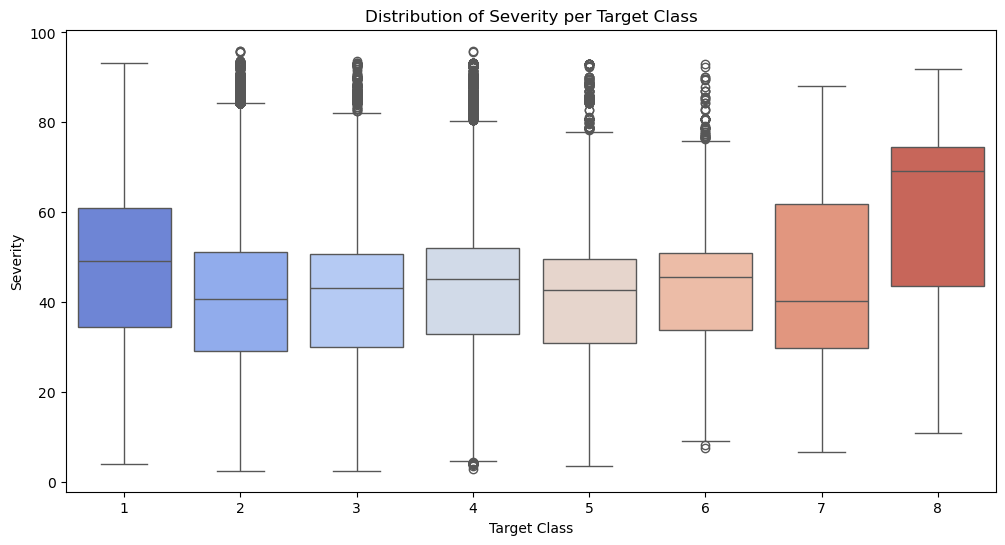

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame
plt.figure(figsize=(12, 6))
sns.boxplot(x='numeric_target', y='severity', data=data, palette='coolwarm')
plt.title('Distribution of Severity per Target Class')
plt.xlabel('Target Class')
plt.ylabel('Severity')
plt.show()

/tmp/ipykernel_13706/3479186882.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='numeric_target', y='wcio_part_of_body_code', data=data, palette='coolwarm')


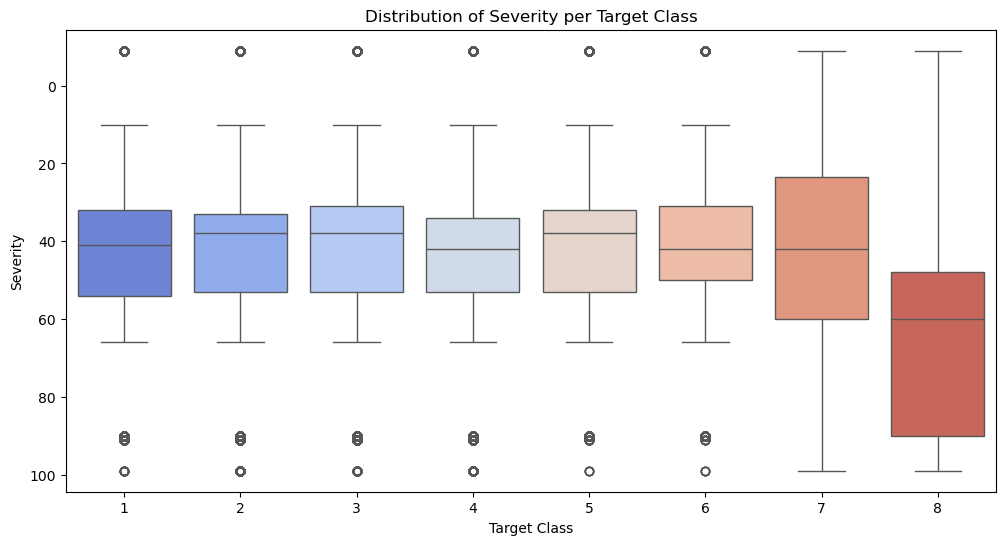

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame
plt.figure(figsize=(12, 6))
sns.boxplot(x='numeric_target', y='wcio_part_of_body_code', data=data, palette='coolwarm')
plt.title('Distribution of Severity per Target Class')
plt.xlabel('Target Class')
plt.ylabel('Severity')
plt.show()


### Cause of Injury

Causes of injury were grouped by the nature of root cause, surmizing that some injury types would be more likely to be associated with certain claim injury types.

In [59]:
# Dictionary of injury groups based on type of injury
cause_of_injury_groups = \
    {
        'I. Burn or Scald – Heat or Cold Exposures – Contact With' : (1,2,3,4,5,6,7,8,9,11,14,84), 
        'II. Caught In, Under or Between': (10,12,13,20),
        'III. Cut, Puncture, Scrape Injured By': (15,16,17,18,19),
        'IV. Fall, Slip or Trip Injury': (25,26,27,28,29,30,31,32,33),
        'V. Motor Vehicle': (40,41,45,46,47,48,50),
        'VI.  Strain or Injury By': (52,53,54,55,56,57,58,59,60,61,62,97),
        'VII. Striking Against or Stepping On': (65,66,67,68,69,70),
        'VIII. Struck or Injured By': (74,75,76,77,78,79,80,81,85,86),
        'IX.  Rubbed or Abraded By': (94,95),
        'X. Miscellaneous Causes':(82,83,87,88,89,90,91,93,96,98,99)
    }

In [60]:
# Mapping for train
train['cause_of_injury_group'] = \
    train['wcio_cause_of_injury_code'].map(
        {v: k for k, vals in cause_of_injury_groups.items() for v in vals}
    )

# Casting as category
train['cause_of_injury_group'] = \
    train['cause_of_injury_group'].apply(
        lambda x: x if x else np.nan
    ).astype('category')

In [61]:
# Mapping for test
test['cause_of_injury_group'] = \
    test['wcio_cause_of_injury_code'].map(
        {v: k for k, vals in cause_of_injury_groups.items() for v in vals}
    )

# Casting as category
test['cause_of_injury_group'] = \
    test['cause_of_injury_group'].apply(
        lambda x: x if x else np.nan
    ).astype('category')

In [62]:
# Appended to the categorical features list
categorical_features.append('cause_of_injury_group')

### Part of Body

In a similar argument, certain parts of the body were hypothesized would correlated more to certain classes of claim, so these were also grouped.

In [63]:
# The apparent error code '-9' was transformed to '90' as this values was in line with the descriptions for this feature.
train['wcio_part_of_body_code'] = train['wcio_part_of_body_code'].where(train['wcio_part_of_body_code'] != -9, 90)

In [64]:
# Injury part of body dictionary is created
parts_of_body_groups = \
    {
        'I. Head': tuple(range(10,20)),
        'II. Neck': tuple(range(20,27)),
        'III. Back': tuple(range(30,40)),
        'IV. Upper Extremities': (41,42,43,44,45,46,47,48,49,60,61,62,63),
        'V. Lower Extremities': tuple(range(50,60)),
        'VI. Multiple Body Parts': (64,65,66,90,91,99)
    }


In [65]:
# Mapped to a variable and assigned to train
train['part_of_body_group'] = \
    train['wcio_part_of_body_code'].map(
        {v: k for k, vals in parts_of_body_groups.items() for v in vals}
    )

# Cast as a category
train['part_of_body_group'] = \
    train['part_of_body_group'].apply(
        lambda x: x if x else np.nan
    ).astype('category')

In [66]:
# Mapped to a variable assigned to test
test['part_of_body_group'] = \
    test['wcio_part_of_body_code'].map(
        {v: k for k, vals in parts_of_body_groups.items() for v in vals}
    )

# Cast as a category
test['part_of_body_group'] = \
    test['part_of_body_group'].apply(
        lambda x: x if x else np.nan
    ).astype('category')

## Garbage collection and Housekeeping

The thorough exploration of the original variables, and the engineered variables led to the rejection of the more natural candidates, such as columns with no association with the targets classes; columns with no association to the target classes; columns that were transformed and which's components were more usefull and purported to the same facts; unary columns resulting from time intelligence and missingness operations.

### Providing some summaries

Below we show the summary information of the transformations that were applied.

In [67]:
compare_dataframe_columns(train, test)

The dataframes do not have the same columns.
Columns in df1 but not in df2: {'claim_injury_type'}
Columns in df2 but not in df1: set()


In [68]:
summarize_missing_information(train)

,variable,dtype,count,unique,missing,pc_missing
0,accident_date,datetime64[ns],572325,5488,3689,1
1,age_at_injury,float64,572325,99,5511,1
2,alternative_dispute_resolution,float64,572325,2,0,0
3,assembly_date,datetime64[ns],572325,896,0,0
4,attorney_representative,float64,572325,2,0,0
5,average_weekly_wage,float64,572325,119530,28584,5
6,birth_year,float64,572325,108,28992,5
7,c_2_date,datetime64[ns],572325,2469,0,0
8,c_3_date,datetime64[ns],572325,2568,0,0
9,carrier_name,category,572325,2046,0,0


In [69]:
summarize_missing_information(test)

,variable,dtype,count,unique,missing,pc_missing
0,accident_date,datetime64[ns],387975,3439,2444,1
1,age_at_injury,float64,387975,93,3283,1
2,alternative_dispute_resolution,float64,387975,2,0,0
3,assembly_date,datetime64[ns],387975,434,0,0
4,attorney_representative,float64,387975,2,0,0
5,average_weekly_wage,float64,387975,39009,19204,5
6,birth_year,float64,387975,103,19470,5
7,c_2_date,datetime64[ns],387975,1073,0,0
8,c_3_date,datetime64[ns],387975,1111,0,0
9,carrier_name,category,387975,1598,0,0


In [70]:
summarize_dataframe(train)

,variable,dtype,unique_count,unique_values,value_counts
0,accident_date,datetime64[ns],5487,"[2019-12-30 00:00:00, 2019-08-30 00:00:00, 201...","{2020-03-01 00:00:00: 1244, 2020-12-18 00:00:0..."
1,age_at_injury,float64,98,"[31.0, 46.0, 40.0, 61.0, 67.0]","{31.0: 14028, 30.0: 14013, 32.0: 13978, 29.0: ..."
2,alternative_dispute_resolution,float64,2,"[0.0, 1.0]","{0.0: 569712, 1.0: 2613}"
3,assembly_date,datetime64[ns],896,"[2020-01-01 00:00:00, 2020-01-02 00:00:00, 202...","{2020-03-06 00:00:00: 1410, 2021-05-11 00:00:0..."
4,attorney_representative,float64,2,"[0.0, 1.0]","{0.0: 392155, 1.0: 180170}"
5,average_weekly_wage,float64,119529,"[0.0, 1745.93, 1434.8, nan, 225.0]","{0.0: 335129, 250.0: 3192, 600.0: 2315, 1765.0..."
6,birth_year,float64,107,"[1988.0, 1973.0, 1979.0, 1958.0, 1952.0]","{0.0: 24997, 1990.0: 13166, 1989.0: 12849, 197..."
7,c_2_date,datetime64[ns],2469,"[2019-12-31 00:00:00, 2020-01-01 00:00:00, 202...","{2021-05-11 00:00:00: 1844, 2020-03-05 00:00:0..."
8,c_3_date,datetime64[ns],2568,"[2020-01-03 00:00:00, 2020-01-14 00:00:00, 202...","{2021-05-14 00:00:00: 1255, 2022-08-18 00:00:0..."
9,carrier_name,category,2046,"['NEW HAMPSHIRE INSURANCE CO', 'ZURICH AMERICA...","{'STATE INSURANCE FUND': 110816, 'POLICE, FIRE..."


In [71]:
summarize_dataframe(test)

,variable,dtype,unique_count,unique_values,value_counts
0,accident_date,datetime64[ns],3438,"[2022-12-24 00:00:00, 2022-11-20 00:00:00, 202...","{2024-01-16 00:00:00: 1263, 2023-01-17 00:00:0..."
1,age_at_injury,float64,92,"[19.0, 59.0, 55.0, 25.0, 36.0]","{33.0: 10102, 30.0: 9690, 32.0: 9667, 31.0: 95..."
2,alternative_dispute_resolution,float64,2,"[0.0, 1.0]","{0.0: 386314, 1.0: 1661}"
3,assembly_date,datetime64[ns],434,"[2023-01-02 00:00:00, 2023-01-03 00:00:00, 202...","{2023-09-21 00:00:00: 1789, 2023-10-11 00:00:0..."
4,attorney_representative,float64,2,"[0.0, 1.0]","{0.0: 306476, 1.0: 81499}"
5,average_weekly_wage,float64,39008,"[nan, 0.0, 688.2, 1180.74, 224.58]","{0.0: 316549, 450.0: 1121, 325.0: 875, 975.0: ..."
6,birth_year,float64,102,"[2003.0, 1963.0, 0.0, 1997.0, 1986.0]","{0.0: 19596, 1990.0: 9352, 1992.0: 8657, 1991...."
7,c_2_date,datetime64[ns],1073,"[2023-01-02 00:00:00, 2022-12-31 00:00:00, 202...","{2023-10-11 00:00:00: 1688, 2023-08-08 00:00:0..."
8,c_3_date,datetime64[ns],1111,"[2023-01-05 00:00:00, 2023-01-03 00:00:00, 202...","{2023-10-14 00:00:00: 1376, 2023-07-31 00:00:0..."
9,carrier_name,category,1598,"['INDEMNITY INSURANCE CO OF', 'A I U INSURANCE...","{'STATE INSURANCE FUND': 66189, 'AMERICAN ZURI..."


### Identify columns to drop based on different conditions

Columns with low likelyhood to be of interest to the target, or otherwise all usefull information extracted were selectively droped. 

In [72]:
# Columns with all useful information extracted

columns_to_drop_date = train.filter(regex='^(?!.*missing).*date$').columns.tolist()  # ending with 'date'
columns_to_drop_hearing = train.filter(regex='^(?!.*missing).*hearing.$').columns.tolist() # that have 'hearing'
columns_to_drop_fh = train.filter(regex='^(?!.*missing).*_fh_.*$').columns.tolist() # that have '_fh_'

# Columns with unary values
columns_to_drop_unary = [col for col in train.columns if train[col].nunique() == 1 and not col.startswith('do')] # with only one unique value, excluding columns starting with 'do' (the ones that are part of the encoding)

# Combine all columns to drop into a single list (to avoid dropping multiple times)
all_columns_to_drop = set(
    columns_to_drop_date 
    + columns_to_drop_hearing
    + columns_to_drop_fh
    + columns_to_drop_unary 
)

In [73]:
# Update the DataFrame by dropping all identified columns at once
train = train.drop(columns=all_columns_to_drop)

In [74]:
# Use intersection method, to treat the test Dataframe and ensure congurence.
test = test[test.columns.intersection(train.columns)]

## Final analysis and data exportation

The dataframes were inspected one final time, and written to csv, with their names updated to convey that they have undergone treatement, a companion json file was also written to the directory to facilitate data ingestion at the destination.

In [75]:
train.info() # looks_good

<class 'pandas.core.frame.DataFrame'>
Index: 572325 entries, 5393875 to 6165075
Data columns (total 80 columns):
 #   Column                                     Non-Null Count   Dtype   
---  ------                                     --------------   -----   
 0   age_at_injury                              566814 non-null  float64 
 1   alternative_dispute_resolution             572325 non-null  float64 
 2   attorney_representative                    572325 non-null  float64 
 3   average_weekly_wage                        543741 non-null  float64 
 4   birth_year                                 543333 non-null  float64 
 5   carrier_name                               572325 non-null  category
 6   carrier_type                               572325 non-null  category
 7   claim_injury_type                          572325 non-null  category
 8   county_of_injury                           572325 non-null  category
 9   covid_19_indicator                         572325 non-null  float64 

In [76]:
test.info() # looks_good

<class 'pandas.core.frame.DataFrame'>
Index: 387975 entries, 6165911 to 6553594
Data columns (total 79 columns):
 #   Column                                     Non-Null Count   Dtype   
---  ------                                     --------------   -----   
 0   age_at_injury                              384692 non-null  float64 
 1   alternative_dispute_resolution             387975 non-null  float64 
 2   attorney_representative                    387975 non-null  float64 
 3   average_weekly_wage                        368771 non-null  float64 
 4   birth_year                                 368505 non-null  float64 
 5   carrier_name                               387975 non-null  category
 6   carrier_type                               387975 non-null  category
 7   county_of_injury                           387975 non-null  category
 8   covid_19_indicator                         387975 non-null  float64 
 9   district_name                              387975 non-null  category

In [80]:
# The datasets are written to csv in the data directory
train.to_csv('../data/preproc_train.csv', index=True)
test.to_csv('../data/preproc_test.csv', index=True)


In [1]:
# A dictionary of dictionaries is created, where each dictionary contains the feature list and its respective data type
dtypes = {col: str(train[col].dtype) for col in train.columns}

# And is saved to a json in the data directory
with open("../data/dtypes.json", "w") as file:
    json.dump(dtypes, file, indent=4)


NameError: name 'train' is not defined

In [82]:
# gg_ez

 Future considerations:
    word2vec
    
 TODO: